In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.append('../utils')
from preprocessing import clean_text, map_labels_to_binary, encode_categorical_features

print("📊 Starting Data Cleaning Process...")
print("Environment setup complete!")

ModuleNotFoundError: No module named 'preprocessing'

In [2]:
columns = [
    'id', 'label', 'statement', 'subject', 'speaker', 
    'job', 'state', 'party', 'barely_true', 'false', 
    'half_true', 'mostly_true', 'pants_on_fire', 'context'
]

try:
    train_df = pd.read_csv('../data/train.tsv', sep='\t', names=columns, encoding='utf-8')
    test_df = pd.read_csv('../data/test.tsv', sep='\t', names=columns, encoding='utf-8')
    valid_df = pd.read_csv('../data/valid.tsv', sep='\t', names=columns, encoding='utf-8')
    
    print("✅ Data loaded successfully!")
    print(f"Training data: {len(train_df)} samples")
    print(f"Test data: {len(test_df)} samples")
    print(f"Validation data: {len(valid_df)} samples")
    
except FileNotFoundError as e:
    print("❌ Error loading data files!")
    print("Please ensure train.tsv, test.tsv, and valid.tsv are in the data/ folder")
    print("Download from: https://github.com/thiagorainmaker77/liar_dataset")
    sys.exit(1)


✅ Data loaded successfully!
Training data: 10240 samples
Test data: 1267 samples
Validation data: 1284 samples



📊 DATA EXPLORATION

🔍 Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10240 non-null  object 
 1   label          10240 non-null  object 
 2   statement      10240 non-null  object 
 3   subject        10238 non-null  object 
 4   speaker        10238 non-null  object 
 5   job            7343 non-null   object 
 6   state          8032 non-null   object 
 7   party          10238 non-null  object 
 8   barely_true    10238 non-null  float64
 9   false          10238 non-null  float64
 10  half_true      10238 non-null  float64
 11  mostly_true    10238 non-null  float64
 12  pants_on_fire  10238 non-null  float64
 13  context        10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB
None

🔍 First 5 rows:
           id        label                                          st

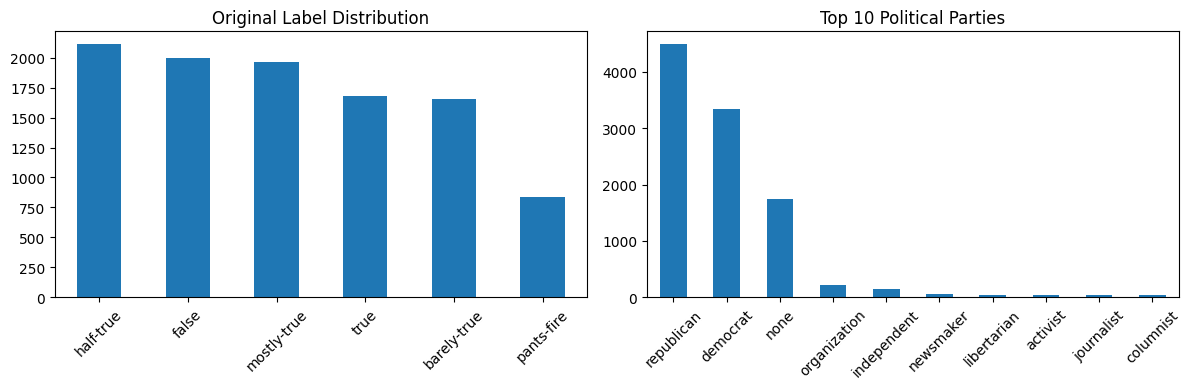

In [3]:
print("\n📊 DATA EXPLORATION")
print("="*50)

print("\n🔍 Training Data Info:")
print(train_df.info())

print("\n🔍 First 5 rows:")
print(train_df.head())

print("\n🔍 Label Distribution:")
print(train_df['label'].value_counts())

print("\n🔍 Missing Values:")
missing_vals = train_df.isnull().sum()
print(missing_vals[missing_vals > 0])

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
train_df['label'].value_counts().plot(kind='bar', rot=45)
plt.title('Original Label Distribution')
plt.tight_layout()

plt.subplot(1, 2, 2)
train_df['party'].value_counts().head(10).plot(kind='bar', rot=45)
plt.title('Top 10 Political Parties')
plt.tight_layout()

plt.show()


In [4]:
print("\n🧹 CLEANING TEXT DATA...")

def process_dataset(df, dataset_name):
    """Process a single dataset with cleaning and feature engineering"""
    print(f"\n🔄 Processing {dataset_name} dataset...")
    
    df_clean = df.copy()

    print("  - Cleaning statement text...")
    df_clean['statement'] = df_clean['statement'].fillna('')
    df_clean['clean_statement'] = df_clean['statement'].apply(clean_text)
    
    print("  - Converting labels to binary...")
    df_clean['label_binary'] = df_clean['label'].apply(map_labels_to_binary)
    
    print("  - Processing metadata...")
    df_clean['party'] = df_clean['party'].fillna('none')
    df_clean['subject'] = df_clean['subject'].fillna('none')
    df_clean['speaker'] = df_clean['speaker'].fillna('unknown')
    df_clean['job'] = df_clean['job'].fillna('unknown')
    df_clean['state'] = df_clean['state'].fillna('unknown')
    
    categorical_cols = ['party', 'subject', 'speaker', 'job', 'state']
    df_clean = encode_categorical_features(df_clean, categorical_cols)
    
    df_clean['statement_length'] = df_clean['clean_statement'].str.len()
    df_clean['word_count'] = df_clean['clean_statement'].str.split().str.len()

    df_clean = df_clean[df_clean['clean_statement'].str.len() > 0]
    
    print(f"  ✅ {dataset_name} processing complete!")
    print(f"     Original size: {len(df)} -> Clean size: {len(df_clean)}")
    
    return df_clean

# Process all datasets
train_clean = process_dataset(train_df, "Training")
test_clean = process_dataset(test_df, "Test")
valid_clean = process_dataset(valid_df, "Validation")




🧹 CLEANING TEXT DATA...

🔄 Processing Training dataset...
  - Cleaning statement text...


NameError: name 'clean_text' is not defined

In [5]:
print("\n📈 DATA QUALITY ANALYSIS")
print("="*50)

def analyze_dataset(df, name):
    """Analyze cleaned dataset quality"""
    print(f"\n📊 {name} Dataset Analysis:")
    print(f"   Total samples: {len(df)}")
    print(f"   Binary label distribution:")
    print(f"     Real news (1): {sum(df['label_binary'] == 1)}")
    print(f"     Fake news (0): {sum(df['label_binary'] == 0)}")
    print(f"   Average statement length: {df['statement_length'].mean():.1f} chars")
    print(f"   Average word count: {df['word_count'].mean():.1f} words")
    
    empty_statements = sum(df['clean_statement'].str.len() == 0)
    if empty_statements > 0:
        print(f"   ⚠  Empty statements found: {empty_statements}")
    else:
        print(f"   ✅ No empty statements")

analyze_dataset(train_clean, "Training")
analyze_dataset(test_clean, "Test")
analyze_dataset(valid_clean, "Validation")

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
train_clean['label_binary'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Binary Labels\n(0=Fake, 1=Real)')
plt.xticks([0, 1], ['Fake', 'Real'], rotation=0)

plt.subplot(2, 3, 2)
plt.hist(train_clean['statement_length'], bins=50, alpha=0.7, color='blue')
plt.title('Statement Length Distribution')
plt.xlabel('Characters')

plt.subplot(2, 3, 3)
plt.hist(train_clean['word_count'], bins=50, alpha=0.7, color='green')
plt.title('Word Count Distribution')
plt.xlabel('Words')

plt.subplot(2, 3, 4)
train_clean['subject'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 Subjects')

plt.subplot(2, 3, 5)
party_counts = train_clean['party'].value_counts().head(8)
plt.pie(party_counts.values, labels=party_counts.index, autopct='%1.1f%%')
plt.title('Political Party Distribution')

plt.subplot(2, 3, 6)
party_label_crosstab = pd.crosstab(train_clean['party'], train_clean['label_binary'])
party_label_crosstab.head(10).plot(kind='bar', stacked=True, color=['red', 'green'])
plt.title('Real vs Fake by Party')
plt.xticks(rotation=45)
plt.legend(['Fake', 'Real'])

plt.tight_layout()
plt.show()



📈 DATA QUALITY ANALYSIS


NameError: name 'train_clean' is not defined

In [6]:
print("\n🔧 FEATURE ENGINEERING...")

def create_additional_features(df):
    """Create additional features for better model performance"""
    df_features = df.copy()
    
    df_features['has_question'] = df_features['clean_statement'].str.contains('\?').astype(int)
    df_features['has_exclamation'] = df_features['statement'].str.contains('!').astype(int)
    df_features['has_quotes'] = df_features['statement'].str.contains('"').astype(int)
    df_features['uppercase_ratio'] = df_features['statement'].apply(
        lambda x: sum(c.isupper() for c in str(x)) / max(len(str(x)), 1)
    )
    
    df_features['avg_word_length'] = df_features['clean_statement'].apply(
        lambda x: np.mean([len(word) for word in str(x).split()]) if str(x).split() else 0
    )
    
    df_features['party_subject'] = df_features['party'] + '_' + df_features['subject']
    
    print(f"  ✅ Created {len(df_features.columns) - len(df.columns)} additional features")
    return df_features

train_final = create_additional_features(train_clean)
test_final = create_additional_features(test_clean)
valid_final = create_additional_features(valid_clean)




🔧 FEATURE ENGINEERING...


NameError: name 'train_clean' is not defined

In [7]:
print("\n💾 SAVING CLEANED DATA...")

important_columns = [
    'id', 'statement', 'clean_statement', 'label', 'label_binary',
    'subject', 'speaker', 'party', 'job', 'state',
    'subject_code', 'party_code', 'speaker_code', 'job_code', 'state_code',
    'statement_length', 'word_count', 'has_question', 'has_exclamation',
    'has_quotes', 'uppercase_ratio', 'avg_word_length'
]

available_columns = [col for col in important_columns if col in train_final.columns]

train_final[available_columns].to_csv('../data/train_clean.csv', index=False)
test_final[available_columns].to_csv('../data/test_clean.csv', index=False)
valid_final[available_columns].to_csv('../data/valid_clean.csv', index=False)

print("✅ Cleaned data saved successfully!")
print(f"   📄 train_clean.csv: {len(train_final)} rows")
print(f"   📄 test_clean.csv: {len(test_final)} rows") 
print(f"   📄 valid_clean.csv: {len(valid_final)} rows")




💾 SAVING CLEANED DATA...


NameError: name 'train_final' is not defined

In [8]:
print("\n📋 CREATING DATA SUMMARY REPORT...")

# Create comprehensive summary
summary_report = {
    'Dataset': ['Training', 'Test', 'Validation'],
    'Original_Size': [len(train_df), len(test_df), len(valid_df)],
    'Clean_Size': [len(train_final), len(test_final), len(valid_final)],
    'Real_News': [
        sum(train_final['label_binary'] == 1),
        sum(test_final['label_binary'] == 1), 
        sum(valid_final['label_binary'] == 1)
    ],
    'Fake_News': [
        sum(train_final['label_binary'] == 0),
        sum(test_final['label_binary'] == 0),
        sum(valid_final['label_binary'] == 0)
    ],
    'Avg_Length': [
        train_final['statement_length'].mean(),
        test_final['statement_length'].mean(),
        valid_final['statement_length'].mean()
    ]
}

summary_df = pd.DataFrame(summary_report)
print(summary_df)

# Save summary report
summary_df.to_csv('../data/data_summary.csv', index=False)

print("\n🎉 DATA CLEANING COMPLETE!")
print("📁 Files created for team:")
print("   - train_clean.csv")
print("   - test_clean.csv") 
print("   - valid_clean.csv")
print("   - data_summary.csv")
print("\n👥 Next: Share data/ folder with Member 2 (TF-IDF Model)")



📋 CREATING DATA SUMMARY REPORT...


NameError: name 'train_final' is not defined

In [10]:
print("\n📝 SAMPLE CLEANED DATA FOR TEAM REVIEW:")
print("="*60)

sample_data = train_final[['statement', 'clean_statement', 'label', 'label_binary', 
                          'party', 'subject', 'statement_length']].head(3)

for idx, row in sample_data.iterrows():
    print(f"\n🔍 Sample {idx + 1}:")
    print(f"   Original: {row['statement'][:100]}...")
    print(f"   Cleaned:  {row['clean_statement'][:100]}...")
    print(f"   Label:    {row['label']} -> {row['label_binary']} ({'Real' if row['label_binary'] else 'Fake'})")
    print(f"   Party:    {row['party']}")
    print(f"   Subject:  {row['subject']}")
    print(f"   Length:   {row['statement_length']} characters")
    print("-" * 60)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 15)